In [55]:
!pip install wordcloud

In [56]:
import json
import re
import numpy as np
import ast
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from typing import List, Dict
from collections import defaultdict
from fuzzywuzzy import process
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Data Cleaning and Data Prepossesing

The primary purpose of this notebook is for preliminary data cleaning and data inspection, as the dataset is very raw from the first glance. 

We begin by loading the dataset from [Huggingface](https://huggingface.co/datasets/devlocalhost/prescription-full/viewer/default/train). The 'results' field of the original dataset is in a string format, so we have to turn it into a dictionary.

In [17]:
ds = load_dataset("devlocalhost/prescription-full")
dataset = ds["train"]
dictionized_dataset = []
for row in ds['train']:
    text = row['text']
    results = ast.literal_eval(row['results'])
    newrow = {'text': text, 'results': results}
    dictionized_dataset.append(newrow)

For the purpose of this project, we only care about the information inside 'medicine_details' that is nested inside 'results'

In [28]:
dictionized_dataset[1]['results']['medicine_details']

[{'medicine_name': 'EBAST M TAB',
  'medicine_dosage': '0-0-1',
  'medicine_frequency': 'After Food',
  'course_duration': '15 Days'},
 {'medicine_name': 'AZEE 500MG TAB',
  'medicine_dosage': '1-0-1',
  'medicine_frequency': 'After Food',
  'course_duration': '5 Days'},
 {'medicine_name': 'VOLTOP DSR TAB',
  'medicine_dosage': '1-0-1',
  'medicine_frequency': 'Before Food',
  'course_duration': '5 Days'},
 {'medicine_name': 'ASCORIL D PLUS SYP',
  'medicine_dosage': '1-1-1',
  'medicine_frequency': 'After Food',
  'course_duration': '5 Days'}]

Some major data impurity are as follows:
- Some rows do not have 'medicine_details'
- Some rows, with 'medicine_details', do not have 'medicine_name'
- Some rows have 'medicine_name' == 'NA' (There are more than 20000 of them!)
- Some rows, even though have valid 'medicine_name', contains typo in its original 'text'(prescription) such that we cannot locate the 'medicine_name' inside the text. 

While we have a simple solution for the first three problems (drop those rows as it is very hard to impute these missing values without extra information), we will try to correct the typos using some techniques for the last problem. Later in this project, we shall compare the difference in model performances between the models trained from the two datasets.

### Dataset 1: Drop all invalid rows

In [50]:
rows_with_med = []
for row in dictionized_dataset:
    if 'medicine_details' in row['results']:
        medicine_details = row['results']['medicine_details']
        if len(medicine_details) > 0:
            row['medicine_details'] = row['results']['medicine_details']
            row['medicine_names'] = [medicine['medicine_name'] for medicine in medicine_details 
                                     if 'medicine_name' in medicine and medicine['medicine_name'] != 'NA' and medicine['medicine_name'] in row['text']]
            rows_with_med.append({'text': row['text'], 'medicine_details': row['medicine_details'], 'medicine_names': row['medicine_names']})

In [51]:
count = 0
for row in rows_with_med:
    for name in row['medicine_names']:
        count += 1

In [52]:
count

28421

In [ ]:
from collections import Counter

total_medicines = sum(len(row['medicine_names']) for row in rows_with_med)
medicine_counter = Counter(name for row in rows_with_med for name in row['medicine_names'])
most_common_medicines = medicine_counter.most_common(10)
unique_medicines = len(medicine_counter)

print(f"Total medicines: {total_medicines}")
print(f"Unique medicines: {unique_medicines}")
print("Top 10 most common medicines:")
for medicine, count in most_common_medicines:
    print(f"{medicine}: {count}")

Total medicines: 28421
Unique medicines: 13096
Top 10 most common medicines:
T. Trapic: 33
Dolo 650: 30
ORS: 30
Syrup Allegra: 26
Tab. Nejor: 26
Tab. Defical: 26
Syrup Cetzine: 26
Betadine ointment: 26
OMNACORTIL 20MG TABLET: 25
PANTIN 40MG TABLET: 25


Here are the purpose of the above drugs
- T. Trapic: To treat abnormal blood loss during or after a surgical procedure or during periods.
- Dolo 650: To relieve pain relief and control fever.
- ORS (Oral Rehydration Salts): Treat or prevent dehydration that may occur with severe diarrhea, especially in babies and young children.
- Syrup Allegra: Treat Allergies

These findings demonstrate that the dataset primarily includes widely used and essential medicines, confirming its practical significance.

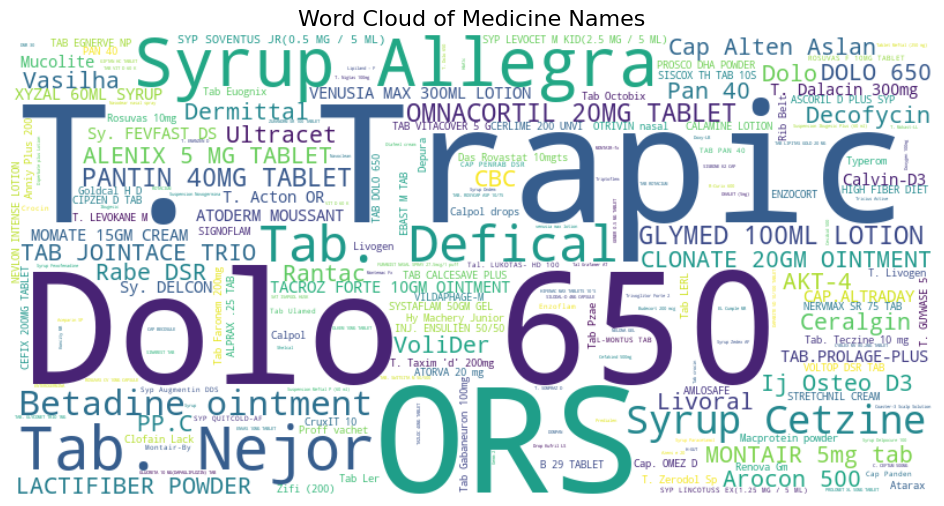

In [61]:
medicine_names = [name for row in rows_with_med for name in row.get("medicine_names", [])]
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(medicine_counter)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Medicine Names", fontsize=16)
plt.show()

Next, we will need to perform text cleaning to remove unnecessary informations inside the raw text (original prescription)

In [6]:
def clean_text(text: str) -> str:
    # Remove doctor signatures
    text = re.sub(r'Dr\.\s+\w+\s+\w+', '', text)
    # Remove phone numbers
    text = re.sub(r'\d{10}', '', text)
    # Remove email addresses
    text = re.sub(r'info@[\w\.]+', '', text)
    # Remove website URLs
    text = re.sub(r'www\.[\w\.]+', '', text)
    # Remove extra whitespaces and newlines
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

In [63]:
for row in rows_with_med:
    row['text'] = clean_text(row['text'])

In [67]:
print(rows_with_med[0]['text'])

balaji gynae & neuro clinic max v md (medicine), dm (neurology) healthcare mbbs, ms (obs & gynae) associate director neurology ior consultant gynaecologist max hospital, patparganj & vaishali hospital, vaishali & paras hospital, vaishali dmc : 8093 | ph. : 15941 sharad vihar clinic : 6:00 pm - 9:00 pm (mon. to fri.) ali clinic : 11:00 am - 1:00 pm (mon. to sun.) vaishali clinic : 11:00 am - 1:00 pm (sun.) d vihar : by appointment for appointment : appointment : ph. : date 22/3/23 mrs neelofer age /sex 29/f nev. reported grade 3 av pari now mainly archiunal w deficit cap pregaind me ff × 1 week -1 x b.auyan < p bd bir - 1 etoshivic 90 my 10g t lyse bring graphy 1 month carpal tunnel 1pling vaishali clinic : plot no. 319, sharad vihar clinic : 5, sharad vihar, delhi-92 o sector 3a, pnb road, vaishali (near karkardooma metro station)


We now proceed with tagging the entities.

1. **B - Begin**:
   - Indicates that the token is the beginning of a named entity.
   - **Example**: In `["B-MEDICINE_NAME"]`, the token is the start of a medicine name entity.

2. **I - Inside**:
   - Indicates that the token is inside a named entity.
   - **Example**: In `["I-MEDICINE_NAME"]`, the token is part of the same medicine name entity.

3. **O - Outside**:
   - Indicates that the token does not belong to any named entity.
   - **Example**: `["O"]` is used for tokens like stopwords or non-entity words.


In [75]:
def tagging_entities(text_corrected: str, entities: List[Dict[str, str]]) -> List[str]:
    """
    Tags entities in the text using BIO tagging for multiple entity types.

    Args:
        text_corrected (str): The cleaned and typo-corrected text.
        entities (List[Dict[str, str]]): A list of dictionaries containing 'label' and 'text' for each entity.

    Returns:
        List[str]: A list of BIO tags corresponding to each token in the text.
    """
    tokens = text_corrected.split()
    BIO = ["O"] * len(tokens)

    for entity in entities:
        label = entity['label']
        entity_text = entity['text']
        pattern = re.compile(r'\b' + re.escape(entity_text) + r'\b', re.IGNORECASE)

        for match in pattern.finditer(text_corrected):
            start_char, end_char = match.start(), match.end()
            current_pos = 0
            for idx, token in enumerate(tokens):
                token_start = text_corrected.find(token, current_pos)
                if token_start == -1:
                    continue
                token_end = token_start + len(token)
                current_pos = token_end
                if token_start >= start_char and token_end <= end_char:
                    if token_start == start_char:
                        BIO[idx] = f'B-{label}'
                    else:
                        BIO[idx] = f'I-{label}'
    return BIO

In [76]:
for row in rows_with_med:
    entities = []
    for medicine_name in row["medicine_names"]:
        entities.append({"label": "MEDICINE_NAME", "text": medicine_name})
    row["BIO"] = tagging_entities(row["text"], entities)

In [77]:
rows_with_med[2]['BIO']

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-MEDICINE_NAME',
 'I-MEDICINE_NAME',
 'I-MEDICINE_NAME',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [78]:
dataset1 = Dataset.from_list(rows_with_med)

In [79]:
dataset1

Dataset({
    features: ['text', 'medicine_details', 'medicine_names', 'BIO'],
    num_rows: 12648
})

We then tokenize the datset for training.

In [ ]:
def tokenize_and_align_labels(examples, tokenizer, label_list):
    # Tokenize input text
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_offsets_mapping=True  # Return offsets to map labels to tokens
    )

    labels = []
    for i, bio_tags in enumerate(examples["BIO"]):  # Iterate over each example's BIO tags
        offset_mapping = tokenized_inputs["offset_mapping"][i]
        label_ids = []
        word_idx = 0  # Keep track of the word index in BIO tags
        for idx, (start, end) in enumerate(offset_mapping):
            if start == 0 and end == 0:  # Special tokens like [CLS] and [SEP]
                label_ids.append(-100)
            else:
                # Assign the label for the current token
                if start == 0 or (idx > 0 and offset_mapping[idx - 1][1] == start):
                    # Assign the current word's label (BIO tag)
                    if word_idx < len(bio_tags):
                        label = bio_tags[word_idx]
                        word_idx += 1
                    else:
                        label = "O"
                else:
                    # For subword tokens, inherit the `I-` label
                    if label.startswith("B-"):
                        label = label.replace("B-", "I-")
                label_id = label_list.index(label) if label in label_list else label_list.index("O")
                label_ids.append(label_id)

        labels.append(label_ids)

    # Add aligned labels to tokenized dataset
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [83]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

label_list = [
    "O",
    "B-MEDICINE_NAME",
    "I-MEDICINE_NAME",
    "B-MEDICINE_DOSAGE",
    "I-MEDICINE_DOSAGE",
    "B-MEDICINE_FREQUENCY",
    "I-MEDICINE_FREQUENCY",
    "B-COURSE_DURATION",
    "I-COURSE_DURATION"
]
tokenized_dataset = dataset1.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "BIO", "medicine_details", "medicine_names"],
    fn_kwargs={"tokenizer": tokenizer, "label_list": label_list}
)

print(tokenized_dataset[0])

Map:   0%|          | 0/12648 [00:00<?, ? examples/s]

{'input_ids': [101, 21451, 4478, 1043, 18279, 2063, 1004, 11265, 10976, 9349, 4098, 1058, 9108, 1006, 4200, 1007, 1010, 1040, 2213, 1006, 11265, 10976, 6483, 1007, 9871, 16914, 5910, 1010, 5796, 1006, 27885, 2015, 1004, 1043, 18279, 2063, 1007, 5482, 2472, 11265, 10976, 6483, 22834, 2099, 8930, 1043, 18279, 8586, 8662, 4098, 2902, 1010, 6986, 19362, 22738, 1004, 12436, 24032, 3669, 2902, 1010, 12436, 24032, 3669, 1004, 11498, 2015, 2902, 1010, 12436, 24032, 3669, 1040, 12458, 1024, 3770, 2683, 2509, 1064, 6887, 1012, 1024, 18914, 23632, 21146, 12173, 6819, 8167, 9349, 1024, 1020, 1024, 4002, 7610, 1011, 1023, 1024, 4002, 7610, 1006, 12256, 1012, 2000, 10424, 2072, 1012, 1007, 4862, 9349, 1024, 2340, 1024, 4002, 2572, 1011, 1015, 1024, 4002, 7610, 1006, 12256, 1012, 2000, 3103, 1012, 1007, 12436, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [85]:
tokenized_dataset.save_to_disk("dataset1")

Saving the dataset (0/1 shards):   0%|          | 0/12648 [00:00<?, ? examples/s]